# Summary
The goal of this program is to solve CAPTCHAs containing 5 letters or digits that are corrupted in various ways. The data consists of 1070 labeled images, which are split into a training set and a small test set. The model used is a Convolutional Neural Network. The images are first preprocessed to remove as much of the corruption as possible, and then cropped to obtain 5200 images of single symbols. The model is then trained on this data and validated using cross-validation. Finally, the model is used on the test data to visualize the performance of the model.

The model performed well on the test set, having 90%  accuracy. This is higher than expected, probably due to the small size of the test set. The model has a validation accuracy of approximately 93.8% on individual symbols, which gives an expected validation accuracy of 72.6% for the whole CAPTCHA predictions. However, the actual test accuracy could be lower since the validation data was used to tune the hyperparameters of the CNN. 

The performance of the model could be improved in multiple ways. The training set is relatively small, containing only 1040 images, and the performance would increase if more images were used. The cropping function could also be improved, since it struggles with certain letters such as "m", which is much wider than the other symbols in some of the images. 

In [3]:
!pip install python-mnist
!pip install idx2numpy
!pip install pillow
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7919 sha256=e4a2cdab6863b1712b84b3d9dab79009dbfe4a6373a473bce60f0d308cd33aeb
  Stored in directory: /root/.cache/pip/wheels/27/40/a8/6447ee4a00cb87e2084e1ef1df5c38433720cc1090be082842
Successfully built idx2numpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [20]:
#Importing data
X_data=[]
y_data=os.listdir('/content/drive/MyDrive/Data/samples')
for i in range(len(os.listdir('/content/drive/MyDrive/Data/samples'))):
  path=os.path.join('/content/drive/MyDrive/Data/samples', y_data[i])
  X_data.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
  y_data[i]=y_data[i][0:5]
X_data=np.asarray(X_data)

#Making a small test set to visualize results
X_train=X_data[:1040]
y_train=y_data[:1040]
X_test=X_data[1040:]
y_test=y_data[1040:]


x_train=X_train
x_test=X_test



print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.shape))
print('Type of y_train : {}'.format(type(y_train)))
print('Length of y_train : {}'.format(len(y_train)))
print('Type of X_test : {}'.format(type(X_test)))
print('Shape of X_test : {}'.format(X_test.shape))

Type of X_train : <class 'numpy.ndarray'>
Shape of X_train : (1040, 50, 200)
Type of y_train : <class 'list'>
Length of y_train : 1040
Type of X_test : <class 'numpy.ndarray'>
Shape of X_test : (30, 50, 200)


### Visualizing training data

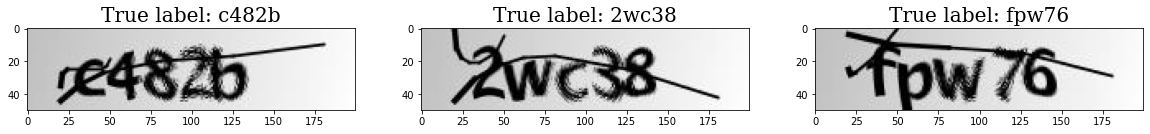

In [21]:
#Three images chosen arbitrarily
img_list = [0, 13, 985]

fig = plt.figure(figsize=(20, 20))
for i,ind in enumerate(img_list):
  fig.add_subplot(1, 3, i+1)
  plt.imshow(x_train[ind], cmap= 'gray')
  plt.title('True label: {}'.format(y_train[ind]),fontdict={'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        })

### Image preprocessing

In [22]:
from skimage.morphology import closing, square

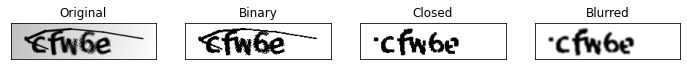

In [23]:
#Example of the image processing done on one image of the training data
img= X_train[7]

ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

closed = closing(thresh1,square(4))

blur = cv2.GaussianBlur(closed, (5, 5), 0)

plt.figure(figsize=(12,4))
plt.subplot(141),plt.imshow(img, cmap= 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow(thresh1, cmap= 'gray'),plt.title('Binary')
plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow(closed, cmap= 'gray'),plt.title('Closed')
plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow(blur, cmap= 'gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])

plt.show()

In [24]:
#Preprocessing all the training images

blurred= np.zeros(((len(y_train), 50, 200)))

for i in range(len(y_train)):
    img= X_train[i]

    #binary
    ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #closing
    closed = closing(thresh1,square(4))
    #blurring
    blur = cv2.GaussianBlur(closed, (5, 5), 0)
    
    blurred[i]= blur

#To use CV the data type needs to be uint8 

for i in range(len(y_train)):
    blurred[i]= blurred[i].astype(np.uint8)
    

### Selecting individual letters

In [25]:
#Building a function that takes in the processed captcha images and splits them in 5, selecting each letter

def select(im):
    width, height = im.size 
    caracters=[]
    top=0
    bottom= 50
    #first character
    left = 0
    right =width/4
    first = im.crop((left,top, right, bottom))
    caracters.append(first)
    #first.show()
    
    for i in range(1):
        left= right
        right= right+(width/8)
        car= im.crop((left,top, right, bottom))
        caracters.append(car)
        #car.show()
    
    for j in range(3):
        left= right
        right= right+(width/9)
        car= im.crop((left,top, right, bottom))
        caracters.append(car)
        #car.show()
    
    return(caracters)
        

In [26]:
#Seperating labels to have them for each character instead of 5 characters at once
#Labels for every num or letter
for i in range(len(y_train)):
    y_train[i]=np.array(list(y_train[i]))
print(y_train[7])

#Storing all the character labels in one list 
L=[]
for i in range(len(y_train)):
    L= L + list(y_train[i])
    
print(len(L))
print(L)
#L contains all the true labels for all the characters

['c' 'f' 'w' '6' 'e']
5200
['c', '4', '8', '2', 'b', '7', 'w', 'n', '7', '4', '2', '2', 'd', '5', 'n', '4', 'y', 'c', '8', '5', 'e', 'n', '4', 'n', '4', '8', 'b', 'b', 'w', '8', 'c', 'n', 'm', 'n', 'n', 'c', 'f', 'w', '6', 'e', '7', 'g', 'm', 'f', '3', '6', '7', 'd', 'e', 'y', 'd', 'n', 'n', 'e', '7', '2', 'e', 'n', '7', 'g', '3', 'b', 'f', 'n', 'd', '2', 'w', 'c', '3', '8', '3', 'n', '2', 'b', '4', '2', 'n', 'p', 'g', '6', '7', 'f', '8', 'b', '3', 'd', 'm', 'x', '8', 'p', '5', '6', 'n', 'c', 'x', '7', 'y', '2', 'x', '4', '6', '3', '8', '2', '4', '7', 'c', 'd', 'g', 'e', '6', '6', '4', 'n', 'f', 'e', '6', 'm', '6', 'p', '5', '5', 'w', '5', 'c', '7', 'g', '3', 'n', 'f', '6', 'f', 'n', '8', '4', 'c', 'f', 'c', '5', '6', '8', 'n', 'p', 'd', '5', '4', 'n', 'c', '3', '7', 'c', 'p', 'e', '6', '3', 'e', 'c', 'd', '4', 'w', 'd', 'd', 'm', 'y', 'g', '7', 'e', '2', 'y', '7', 'e', 'p', '8', '5', 'x', '3', 'n', 'n', 'p', 'w', '6', '7', '8', 'w', '3', '5', '7', 'b', '2', '7', '2', '5', 'e', 'g', 'p

In [27]:
#Processing the single-character images to have them all in one array

#First adding all the images to a list
Train=[]
for i in range(len(y_train)):
    im=Image.fromarray(blurred[i])
    Train.append(select(im))
print(len(Train))

#Making all the images the same size: 50x50 by adding a white strip if image is smaller than 50 pixels wide
for i in range(len(y_train)):
    for j in range(5):
        if Train[i][j].size != (50,50):
            difference= 50-(Train[i][j].size[0])
            new= Image.new('F', (50,50), color=255)
            im= Image.fromarray(255*np.ones((50,difference)))
            new.paste(im)
            new.paste(Train[i][j])
            Train[i][j]=new

1040


In [28]:
#Now storing all these newly sized image in a numpy array "X_train"
X_train= np.zeros((len(L),50,50))
print(X_train.shape)
for i in range(len(y_train)):
    for j in range(5):
        X_train[(i*5)+j]= np.asarray(Train[i][j])
print(X_train.shape)


(5200, 50, 50)
(5200, 50, 50)


In [29]:
#Expanding dimension to make it fit in the neural network
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(5200, 50, 50, 1)


In [30]:
#Doing the same steps for test data
blurred_test= np.zeros((30, 50, 200))

for i in range(30):
    img= X_test[i]

    #binary
    ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #closing
    closed = closing(thresh1,square(4))
    #blurring
    blur = cv2.GaussianBlur(closed, (5, 5), 0)
    
    blurred_test[i]= blur

for i in range(30):
    blurred_test[i]= blurred_test[i].astype(np.uint8)

Test=[]
for i in range(30):
    im=Image.fromarray(blurred_test[i])
    Test.append(select(im))

for i in range(30):
    for j in range(5):
        if Test[i][j].size != (50,50):
            difference= 50-(Test[i][j].size[0])
            new= Image.new('F', (50,50), color=255)
            im= Image.fromarray(255*np.ones((50,difference)))
            new.paste(im)
            new.paste(Test[i][j])
            Test[i][j]=new

X_test= np.zeros((150,50,50))
print(X_test.shape)

for i in range(30):
    for j in range(5):
        X_test[(i*5)+j]= np.asarray(Test[i][j])
print(X_test.shape)

X_test_exp = np.expand_dims(X_test, axis=3)
print(X_test_exp.shape)


(150, 50, 50)
(150, 50, 50)
(150, 50, 50, 1)


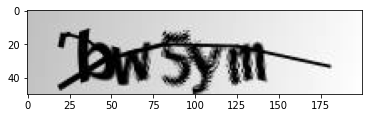

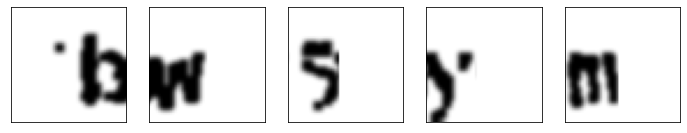

In [31]:
#Showing the preprocessing on an example from the test set
plt.imshow(x_test[1], cmap='gray')

plt.figure(figsize=(12,4))
plt.subplot(151),plt.imshow(X_test[5], cmap= 'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(152),plt.imshow(X_test[6], cmap= 'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(153),plt.imshow(X_test[7], cmap= 'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(154),plt.imshow(X_test[8], cmap= 'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(155),plt.imshow(X_test[9], cmap= 'gray')
plt.xticks([]), plt.yticks([])

plt.show()

### Building the Neural Network

In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
import keras

In [32]:
#Replacing the letters of labels with integers for one hot encoding: a=10... z=36

letters= ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v','w','x', 'y','z']
labels= [i for i in range (10,37)]


for j in range(len(L)):
    for k in range(len(letters)):
        if L[j]== letters[k]:
            L[j]= labels[k]

#One hot encoding
y_train_one_hot = keras.utils.to_categorical(L, 36)

In [33]:
#Checking the format
print(y_train_one_hot[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
#To help the neural network, values of pixels should be between 0 and 1, so dividing by 255
for i in range(len(X_train)):
    X_train[i]= np.true_divide(X_train[i], 255)

for i in range(150):
    X_test_exp[i]= np.true_divide(X_test_exp[i], 255)


In [35]:
#Building the model for neural network
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(50,50,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

#compliling model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#Showing summary
model.summary()

#Saving weights so the model can be reset for cross validation
model.save_weights('model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 128)       147584    
                                                        

In [ ]:

from sklearn.model_selection import KFold

#Fitting the model to the training data using k-fold cross validation, with k=10
k_fold = KFold(10)
val_accuracy=[]
for k, (train, test) in enumerate(k_fold.split(X_train, y_train_one_hot)):
  print('fold: {}'.format(k))
  model.load_weights('model.h5')
  hist = model.fit(X_train[train], y_train_one_hot[train], batch_size=32, epochs=12, validation_data=(X_train[test], y_train_one_hot[test]))
  val_accuracy.append(hist.history['val_accuracy'][-1])

fold: 0
Epoch 1/12
147/147 [==============================] - 2s 16ms/step - loss: 2.6489 - accuracy: 0.1989 - val_loss: 1.4162 - val_accuracy: 0.5577
Epoch 2/12
147/147 [==============================] - 2s 16ms/step - loss: 1.3606 - accuracy: 0.5904 - val_loss: 0.7016 - val_accuracy: 0.7885
Epoch 3/12
147/147 [==============================] - 2s 16ms/step - loss: 0.7530 - accuracy: 0.7707 - val_loss: 0.3685 - val_accuracy: 0.9038
Epoch 4/12
147/147 [==============================] - 2s 16ms/step - loss: 0.4953 - accuracy: 0.8415 - val_loss: 0.2562 - val_accuracy: 0.9385
Epoch 5/12
147/147 [==============================] - 2s 16ms/step - loss: 0.3706 - accuracy: 0.8855 - val_loss: 0.1756 - val_accuracy: 0.9519
Epoch 6/12
147/147 [==============================] - 2s 16ms/step - loss: 0.3023 - accuracy: 0.9026 - val_loss: 0.1459 - val_accuracy: 0.9692
Epoch 7/12
147/147 [==============================] - 2s 16ms/step - loss: 0.2597 - accuracy: 0.9169 - val_loss: 0.1656 - val_accuracy

In [ ]:
#Showing the accuracy
print('The validation accuracies are {}' .format(val_accuracy))
print('The average validation accuracy is: {}' .format(sum(val_accuracy)/len(val_accuracy)))

The validation accuracies are [0.9653846025466919, 0.9307692050933838, 0.9673076868057251, 0.9615384340286255, 0.9596154093742371, 0.9076923131942749, 0.9365384578704834, 0.8961538672447205, 0.9192307591438293, 0.9442307949066162]
The average validation accuracy is: 0.9388461530208587


In [36]:
#Fitting the model to the entire training set
model.load_weights('model.h5') 
hist = model.fit(X_train, y_train_one_hot, batch_size=32, epochs=12)

#Predicting labels for the images in the test set
number_to_class = [str(i) for i in range(10)]+letters
y_pred= []
for k in range(30):
    prediction= []
    for i in range(5):
        probabilities = model.predict(np.array( [X_test_exp[(k*5)+i],] ), verbose=0)
        index = np.argsort(probabilities[0,:])
        prediction.append(number_to_class[index[35]])
    pred = ''.join(prediction)
    y_pred.append(pred)

Epoch 1/12
163/163 [==============================] - 12s 16ms/step - loss: 1.8574 - accuracy: 0.4462
Epoch 2/12
163/163 [==============================] - 2s 15ms/step - loss: 0.4954 - accuracy: 0.8469
Epoch 3/12
163/163 [==============================] - 2s 15ms/step - loss: 0.3139 - accuracy: 0.9029
Epoch 4/12
163/163 [==============================] - 2s 14ms/step - loss: 0.2263 - accuracy: 0.9258
Epoch 5/12
163/163 [==============================] - 2s 14ms/step - loss: 0.1873 - accuracy: 0.9394
Epoch 6/12
163/163 [==============================] - 2s 14ms/step - loss: 0.1487 - accuracy: 0.9492
Epoch 7/12
163/163 [==============================] - 2s 15ms/step - loss: 0.1434 - accuracy: 0.9540
Epoch 8/12
163/163 [==============================] - 2s 15ms/step - loss: 0.1136 - accuracy: 0.9615
Epoch 9/12
163/163 [==============================] - 2s 14ms/step - loss: 0.1035 - accuracy: 0.9665
Epoch 10/12
163/163 [==============================] - 2s 14ms/step - loss: 0.1039 - accur

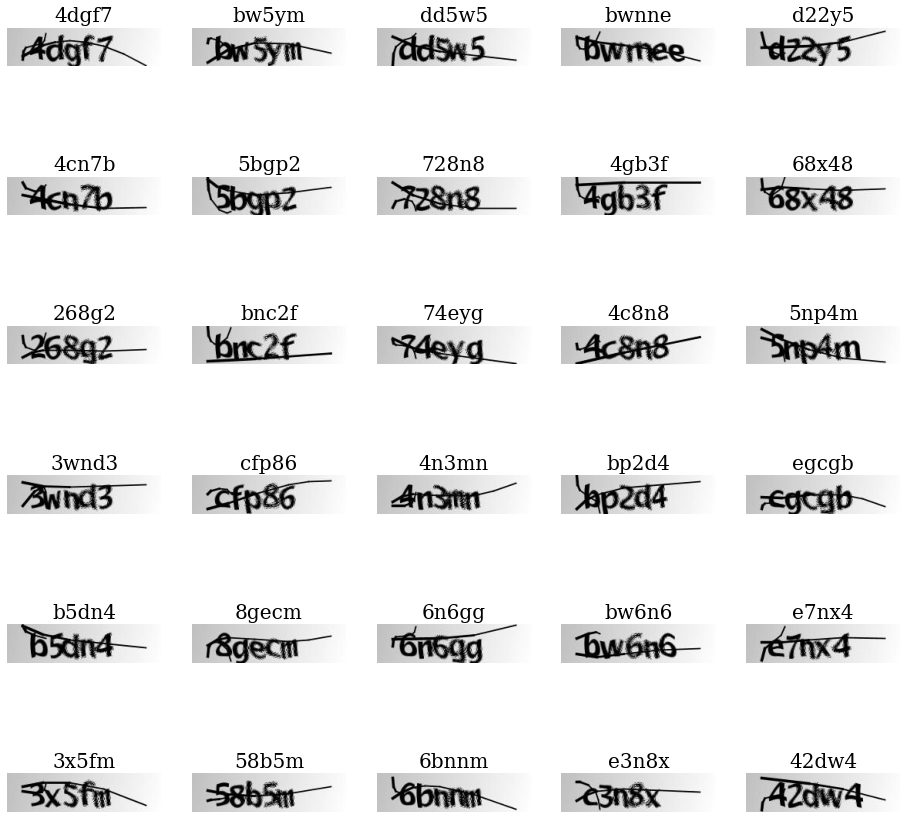

In [37]:
#Displaying the prediction
fig = plt.figure(figsize=(16, 16))
for i in range(30):
  fig.add_subplot(6, 5, i+1)
  plt.imshow(x_test[i], cmap= 'gray')
  plt.title(y_pred[i],fontdict={'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        })
  plt.axis('off')